# Machine learning with graphs

## Assignment 3 (16/03/2021)

Solution notebook for Homeworks proposed in the [MLG](http://jcid.webs.tsc.uc3m.es/machine-learning-group/) in the seminar of 2021 based on [Machine learning with graphs](http://snap.stanford.edu/class/cs224w-2019/) course by Standford university.

    Author: Daniel Bacaicoa Barber (13 mar, 2021)


In [1]:
#Importing generic libraries.
import numpy as np
import pandas as pd
import scipy 

# Graph related libraries 
import networkx as nx

# Util libraries
from collections import Counter, OrderedDict
import itertools
import random

#Plotting library
import matplotlib.pyplot as plt

### 2 Structural Roles: Rolx and ReFex

In this problem, we will explore the structural role extraction algorithm Rolx and its recursive feature extraction method ReFex. As part of this exploration, we will work with a dataset representing a scientist co-authorship network, which can be dowloaded at http://www-personal.umich.edu/~mejn/netdata/netscience.zip. 

Although the graph is weighted, for simplicity we treat it as **undirected and unweighted** in this problem.


Feature extraction consists of two steps; we first extract basic local features from every node, and we subsequently aggregate them along graph edges so that global features are also obtained.

Collectively, feature extraction constructs a matrix $V \in \mathbb{R}^{n\times f}$ where for each of the n nodes we have $f$ features to cover local and global information. RolX extracts node roles from that matrix.

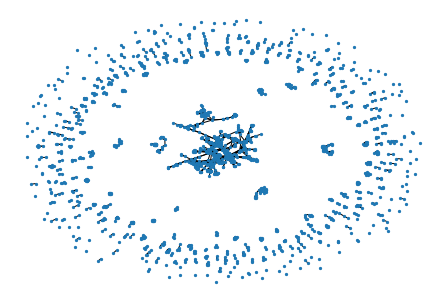

In [2]:
G = nx.read_gml("netscience.gml")
nx.draw(G,node_size = 5,arrowsize = 10)

In [3]:
# We make the computation in order to get the adjacency matrix
A = nx.adjacency_matrix(G)
A = A.todense()

print('Number of nodes is:',A.shape[0])

Number of nodes is: 1589


In [4]:
Nodes = np.array(list(G.nodes()))
print('The name of the first 5 nodes is: ',Nodes[:5])

The name of the first 5 nodes is:  ['ABRAMSON, G' 'KUPERMAN, M' 'ACEBRON, J' 'BONILLA, L' 'PEREZVICENTE, C']


In [5]:
#The graph is indirected and without self loops.
print('All the elements in the digonal are set to 0? ',(np.diag(A)==0).all())
print('Is the matrix is symmetric? ',(A.T==A).all())

All the elements in the digonal are set to 0?  True
Is the matrix is symmetric?  True


#### 2.1 Basic Features

We begin by loading the graph G provided in the bundle and computing three basic features for the nodes. For each node $v$, we choose 3 basic local features (in this order):

1. The degree of $v$, i.e., deg($v$)

In [6]:
Degree = A.sum(axis=1)
print('The degree of the 10 first nodes is:\n',Degree[1:10,0])

The degree of the 10 first nodes is:
 [[3.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [1.]
 [6.]]


In [7]:
# We will print this information for certain nodes
i = 9
print('The degree of the %ith node named %s is: %i'%(i,Nodes[i],Degree[i]))
i = 1560
print('The degree of the %ith node named %s is: %i'%(i,Nodes[i],Degree[i]))
i = 1572
print('The degree of the %ith node named %s is: %i'%(i,Nodes[i],Degree[i]))

The degree of the 9th node named HUBERMAN, B is: 6
The degree of the 1560th node named ZAKS, M is: 3
The degree of the 1572th node named BRAUN, T is: 5


2. The number of edges in the egonet of $v$, where egonet of $v$ is defined as the subgraph of $G$ induced by $v$ and its neighborhood.

In [8]:
Egonet_edges = []
for node_id in range(A.shape[0]):
    Egon = np.append(np.where(A[node_id,:]==1)[1],node_id)
    Egonet_edges.append(np.sum(A[Egon[:,None], Egon[None,:]])/2)
Egonet_edges = np.array(Egonet_edges).reshape(-1,1)

#alternatively,
Egonet_edges2 = []
for node in G.nodes():
    Egonet_edges2.append(len(nx.ego_graph(G,node).edges()))
Egonet_edges2 = np.array(Egonet_edges2).reshape(-1,1)   

#Both methods return the same value for the edges of the egonet for each node.
np.sum(Egonet_edges2-Egonet_edges)

0.0

In [9]:
# We will print this information for certain nodes
i = 9
print('The egonet edges of the %ith node named %s is: %i'%(i,Nodes[i],Egonet_edges[i]))
i = 1560
print('The degree of the %ith node named %s is: %i'%(i,Nodes[i],Egonet_edges[i]))
i = 1572
print('The degree of the %ith node named %s is: %i'%(i,Nodes[i],Egonet_edges[i]))

The egonet edges of the 9th node named HUBERMAN, B is: 10
The degree of the 1560th node named ZAKS, M is: 6
The degree of the 1572th node named BRAUN, T is: 15


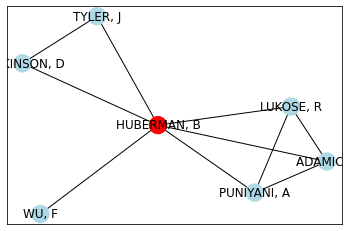

In [13]:
def plot_Egonet(G,node_id):
    A = nx.adjacency_matrix(G)
    A = A.todense()
    egon = np.append(np.where(A[node_id,:]==1)[1],node_id)
    nodes = np.array(list(G.nodes()))
    subgraph = G.subgraph(Nodes[list(egon)])
    color_map = []
    for node in subgraph.nodes():
        if node == nodes[node_id]:
            color_map.append('red')
        else:
            color_map.append('lightblue')
    nx.draw_networkx(subgraph,node_color=color_map)
plot_Egonet(G,9)

3. The number of edges that connect the egonet of $v$ and the rest of the graph, i.e., the number of edges that enter or leave the egonet of $v$.

#### Note:
We will consider a toy example to ilustrate the idea. Let A be the next adjacency matrix for the graph G formed by the nodes $\{v_0,v_1,v_2,v_2,v_4,v_5\}$
$$A = \begin{pmatrix}
0 & 1 & 0 & 1 & 0 & 0\\
1 & 0 & 1 & 1 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 1\\
1 & 1 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
\end{pmatrix}$$ 
whose graphical representation is:
![toy_graph.png](toy_graph.png)


First we will consider the nodes in $v_2$'s egonet, i.e., $v_1, v_2, v_5$. So restricting the adjacency matrix to this set of nodes we have a matix describing the edges in the egonet. 
$$Ego(v_2) =A([1,2,5],[1,2,5])= \begin{pmatrix}
0 & 1 & 0\\
1 & 0 & 1\\
0 & 1 & 0\\
\end{pmatrix}$$ 

Now we can count the connections between the neighborhood of the nodes in the egonet, i.e., $v_1, v_2, v_5, v_0, v_3$. But restricting the matrix to this nodes 
$$Neigh(Ego(v_2)) =A([0,1,2,3,5],[0,1,2,3,5]) = \begin{pmatrix}
0 & 1 & 0 & 1 &  0\\
1 & 0 & 1 & 1 &  0\\
0 & 1 & 0 & 0 &  1\\
1 & 1 & 0 & 0 &  0\\
0 & 0 & 1 & 0 &  0\\
\end{pmatrix}$$ 
includes the count of the edge (0,3) that doesnt go out from the egonet. 

The solution is to restict the Adjacency matrix to the menbers of the egonet in the rows (columns) and tho all the nodes in the neighbourhood in the columns (rows). 

$$Connec(Ego(v_2)) =A([1,2,5],[0,1,2,3,5]) = \begin{pmatrix}
1 & 0 & 1 & 1 &  0\\
0 & 1 & 0 & 0 &  1\\
0 & 0 & 1 & 0 &  0\\
\end{pmatrix}$$ 

This way summing the elements of $Connec(Ego(v_2))$ we have two times the edges in the egonet and all the edges that goes from the egonet to any node in the neighborhood, i.e., to the rest of the graph.  


In [11]:
Out_edges = []
for node_id in range(A.shape[0]):
    Egon = np.append(np.where(A[node_id,:]==1)[1],node_id) #Nodes of the egonet        
    Neighbours = np.where(np.sum(A[Egon,:]==1,0)>0)[1] # Nodes of the egonet and their neighborhood
    Out_edges.append(np.sum(A[Egon[:,None], Neighbours[None,:]]))
    
Out_edges = np.array(Out_edges).reshape(-1,1)
Out_edges = Out_edges - 2*Egonet_edges
print('The #(edges) going out from the egonet of the 10 first nodes is:\n',Out_edges[0:10,0])

The #(edges) going out from the egonet of the 10 first nodes is:
 [1. 0. 0. 0. 0. 0. 0. 3. 3. 1.]


In [12]:
# We will print this information for certain nodes
i = 9
print('The #(edges) going out from the egonet of the %ith node named %s is: %i'%(i,Nodes[i],Out_edges[i]))
i = 1560
print('The #(edges) going out from the egonet of the %ith node named %s is: %i'%(i,Nodes[i],Out_edges[i]))
i = 1572
print('The #(edges) going out from the egonet of the %ith node named %s is: %i'%(i,Nodes[i],Out_edges[i]))

The #(edges) going out from the egonet of the 9th node named HUBERMAN, B is: 1
The #(edges) going out from the egonet of the 1560th node named ZAKS, M is: 24
The #(edges) going out from the egonet of the 1572th node named BRAUN, T is: 7


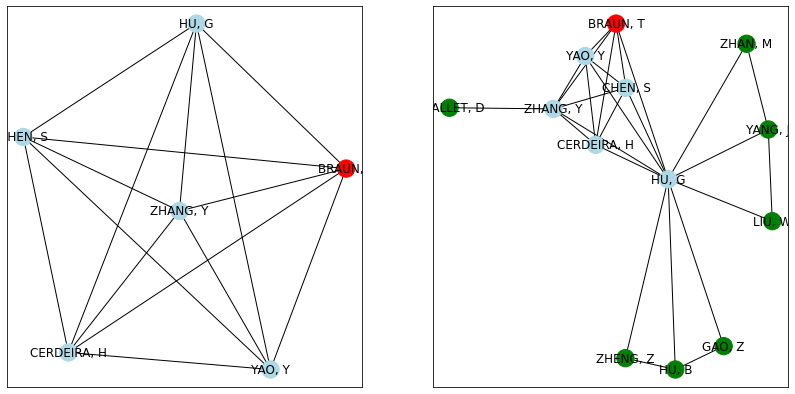

In [17]:
def plot_Egonet_Neig(G,node_id):
    A = nx.adjacency_matrix(G)
    A = A.todense()
    nodes = np.array(list(G.nodes()))
    
    egon = np.append(np.where(A[node_id,:]==1)[1],node_id)
    neighbours = np.where(np.sum(A[egon,:]==1,0)>0)[1]
    
    egonet = G.subgraph(Nodes[list(egon)])
    egonet_neig = G.subgraph(Nodes[list(neighbours)])
    
    color_map_egonet = []
    for node in egonet.nodes():
        if node == nodes[node_id]:
            color_map_egonet.append('red')
        else:
            color_map_egonet.append('lightblue')
            
    color_map_neig = []
    for node in egonet_neig.nodes():
        if node == nodes[node_id]:
            color_map_neig.append('red')
        elif node in egonet.nodes():
            color_map_neig.append('lightblue')
        else:
            color_map_neig.append('green')
            
    plt.figure(figsize=[14,7])
    plt.subplot(121)
    nx.draw_networkx(egonet,node_color=color_map_egonet)
    plt.subplot(122)
    nx.draw_networkx(egonet_neig,node_color=color_map_neig)
plot_Egonet_Neig(G,1572)

Have in mind that not all edges are counted in the second graph. Its only for visualization purposes. Plotting for node 1572 edges going out from the egonet are 7 but 4 edges more are plotted (but not counted).

We use $\tilde{V}_u$ to represent the vector of the basic features of node $u$. For any pair of nodes $u$ and $v$, we can use cosine similarity to measure how similar two nodes are according to their feature vectors $x$ and $y$:

$$Sim(x, y) = \dfrac{x\cdot y}{\Vert x \Vert_2 \cdot \Vert y \Vert_2} = \dfrac{\sum_{i}x_iy_i}{\sqrt{\sum_{i}x_i^2} \cdot \sqrt{\sum_{i}y_i^2}} $$ 

Also, when $\Vert x \Vert_2 = 0$ or $\Vert y \Vert_2 = 0$, we defined $Sim(x, y) = 0$

We stack the features we've just computed

In [19]:
V1 = np.hstack((Degree,Egonet_edges,Out_edges))

We can make it by hand. 

Note that we just sum 0.01 to the norm of the vectors with norm = 0. This only prevents numerical errors. 

In [20]:
def cos_sim(v):
    '''
    input:  a ndarray of size n x n_features
    output: n x n matrix with simmilarities
    '''
    prod = v @ v.T
    norms = np.sqrt(np.sum(np.square(v),axis = 1))
    norms = norms + (norms==0) * 0.01
    return prod / norms / norms.T
Similarities = cos_sim(V1)
Similarities[:5,:5]

matrix([[1.        , 0.96214047, 0.94295417, 0.94295417, 0.94295417],
        [0.96214047, 1.        , 0.96561576, 0.96561576, 0.96561576],
        [0.94295417, 0.96561576, 1.        , 1.        , 1.        ],
        [0.94295417, 0.96561576, 1.        , 1.        , 1.        ],
        [0.94295417, 0.96561576, 1.        , 1.        , 1.        ]])

We can do it more quickly with sklearns pairwise metrics

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
Similarities = cosine_similarity(V1)
Similarities[:5,:5]

array([[1.        , 0.96214047, 0.94295417, 0.94295417, 0.94295417],
       [0.96214047, 1.        , 0.96561576, 0.96561576, 0.96561576],
       [0.94295417, 0.96561576, 1.        , 1.        , 1.        ],
       [0.94295417, 0.96561576, 1.        , 1.        , 1.        ],
       [0.94295417, 0.96561576, 1.        , 1.        , 1.        ]])

Compute the basic feature vector for the node with ID 9, and report the top 5 nodes that are most similar to node 9 (excluding node 9). As a sanity check, no element in $\tilde{V}_9$ is larger than 10.

In [22]:
def top_nodes(sim_matrix,node_id,top_k):
    similarity = np.sort(sim_matrix[node_id,:])[-(top_k+1):-1][::-1]
    possition = np.argsort(sim_matrix[node_id,:])[-(top_k+1):-1][::-1]
    return possition,similarity

Nodes[top_nodes(Similarities,9,5)[0]]

array(['KOCH, C', 'KRZYWICKI, A', 'BURDA, Z', 'MENCZER, F', 'TSALLIS, C'],
      dtype='<U19')

In [23]:
# We will print this information for certain nodes
i = 9
print('Top similarity nodes with node %i, named %s are:\n'%(i,Nodes[i]))
tops = top_nodes(Similarities,i,5)
for j,pos in enumerate(tops[0]):
    print('    Node %i named %s with sim: %0.4f'%(pos,Nodes[pos],tops[1][j]))
    
i = 1560
print('\nTop similarity nodes with node %i, named %s are:\n'%(i,Nodes[i]))
tops = top_nodes(Similarities,i,5)
for j,pos in enumerate(tops[0]):
    print('    Node %i named %s with sim: %0.4f'%(pos,Nodes[pos],tops[1][j]))

i = 1572
print('\nTop similarity nodes with node %i, named %s are:\n'%(i,Nodes[i]))
tops = top_nodes(Similarities,i,5)
for j,pos in enumerate(tops[0]):
    print('    Node %i named %s with sim: %0.4f'%(pos,Nodes[pos],tops[1][j]))

Top similarity nodes with node 9, named HUBERMAN, B are:

    Node 415 named KOCH, C with sim: 0.9996
    Node 288 named KRZYWICKI, A with sim: 0.9963
    Node 286 named BURDA, Z with sim: 0.9963
    Node 1054 named MENCZER, F with sim: 0.9961
    Node 1336 named TSALLIS, C with sim: 0.9961

Top similarity nodes with node 1560, named ZAKS, M are:

    Node 1196 named MUCHA, P with sim: 1.0000
    Node 1561 named PARK, E with sim: 1.0000
    Node 77 named ANCELMEYERS, L with sim: 1.0000
    Node 1195 named PORTER, M with sim: 1.0000
    Node 79 named MARTIN, M with sim: 1.0000

Top similarity nodes with node 1572, named BRAUN, T are:

    Node 1570 named CERDEIRA, H with sim: 1.0000
    Node 1571 named CHEN, S with sim: 1.0000
    Node 1573 named YAO, Y with sim: 1.0000
    Node 283 named VALVERDE, S with sim: 0.9999
    Node 1135 named ONNELA, J with sim: 0.9991


#### 2.2 Recursive Features

In this next step, we recursively generate some more features. We use mean and sum as aggregation functions.

Initially, we have a feature vector $\tilde{V}_u \in \mathbb{R}^3$ for every node $u$. In the first iteration, we concatenate
the mean of all $u$'s neighbors' feature vectors to $\tilde{V}_u$, and do the same for *sum*, i.e.,

$$\tilde{V}_u^{(1)}=\left[\tilde{V}_u;\ \frac{1}{\vert N(u) \vert}\sum_{v\in N(u)} \tilde{V}_u;\ \sum_{v\in N(u)}\tilde{V}_u \right]\in \mathbb{R}^9 $$
where $N(u)$ is the set of $u$'s neighbors in the graph. If $N(u) = \emptyset$, set the mean and sum to 0.



In [28]:
def recursive_feat(v,G):
    A = nx.adjacency_matrix(G)
    A = A.todense()
    
    v2 = np.zeros(v.shape)
    v3 = np.zeros(v.shape)  
    for i,node in enumerate(G.nodes()):
        neig = np.where(A[i,:]==1)[1]
        if neig.size == 0:
            v2[i,:] = np.zeros((1,v.shape[1]))
            v3[i,:] = np.zeros((1,v.shape[1]))
        else:
            v2[i,:] = np.mean(v[neig,:],axis=0)
            v3[i,:] = np.sum(v[neig,:],axis=0)
    return np.hstack((v,v2,v3))

After $K$ iterations, we obtain the overall feature matrix $V = \tilde{V}_u^{(K)} \in \mathbb{R}^{3^{K+1}}$.

For this exercise, run $K = 2$ iterations, and report the top 5 nodes that are most similar to node 9 (excluding node 9). If there are ties, e.g. 4th, 5th, and 6th have the same similarity, report any of them to fill up the top-5 ranking. As a sanity check, the similarities between the reported nodes and node 9 are all greater than 0.9.

In [29]:
V = V1
for i in range(2):
    V = recursive_feat(V,G)
V.shape

(1589, 27)

In [30]:
cos_sim(V)

matrix([[1.        , 0.95150126, 0.88112782, ..., 0.87494102, 0.87494102,
         0.82678243],
        [0.95150126, 1.        , 0.89930483, ..., 0.73418285, 0.73418285,
         0.71654353],
        [0.88112782, 0.89930483, 1.        , ..., 0.59117191, 0.59117191,
         0.71825437],
        ...,
        [0.87494102, 0.73418285, 0.59117191, ..., 1.        , 1.        ,
         0.733178  ],
        [0.87494102, 0.73418285, 0.59117191, ..., 1.        , 1.        ,
         0.733178  ],
        [0.82678243, 0.71654353, 0.71825437, ..., 0.733178  , 0.733178  ,
         1.        ]])

In [31]:
cosine_similarity(V)

array([[1.        , 0.95150126, 0.88112782, ..., 0.87494102, 0.87494102,
        0.82678243],
       [0.95150126, 1.        , 0.89930483, ..., 0.73418285, 0.73418285,
        0.71654353],
       [0.88112782, 0.89930483, 1.        , ..., 0.59117191, 0.59117191,
        0.71825437],
       ...,
       [0.87494102, 0.73418285, 0.59117191, ..., 1.        , 1.        ,
        0.733178  ],
       [0.87494102, 0.73418285, 0.59117191, ..., 1.        , 1.        ,
        0.733178  ],
       [0.82678243, 0.71654353, 0.71825437, ..., 0.733178  , 0.733178  ,
        1.        ]])

In [32]:
# We will print this information for certain nodes
i = 9
print('Top similarity nodes with node %i, named %s are:\n'%(i,Nodes[i]))
tops = top_nodes(cosine_similarity(V),i,5)
for j,pos in enumerate(tops[0]):
    print('    Node %i named %s with sim: %0.4f'%(pos,Nodes[pos],tops[1][j]))
    
i = 1560
print('\nTop similarity nodes with node %i, named %s are:\n'%(i,Nodes[i]))
tops = top_nodes(cosine_similarity(V),i,5)
for j,pos in enumerate(tops[0]):
    print('    Node %i named %s with sim: %0.4f'%(pos,Nodes[pos],tops[1][j]))

i = 1572
print('\nTop similarity nodes with node %i, named %s are:\n'%(i,Nodes[i]))
tops = top_nodes(cosine_similarity(V),i,5)
for j,pos in enumerate(tops[0]):
    print('    Node %i named %s with sim: %0.4f'%(pos,Nodes[pos],tops[1][j]))

Top similarity nodes with node 9, named HUBERMAN, B are:

    Node 973 named CHEN, G with sim: 0.9960
    Node 537 named ENGEL, A with sim: 0.9946
    Node 415 named KOCH, C with sim: 0.9937
    Node 496 named GEISEL, T with sim: 0.9923
    Node 25 named LU, L with sim: 0.9922

Top similarity nodes with node 1560, named ZAKS, M are:

    Node 1283 named ABEL, H with sim: 1.0000
    Node 1560 named ZAKS, M with sim: 1.0000
    Node 1561 named PARK, E with sim: 1.0000
    Node 1554 named CSARDI, G with sim: 0.9992
    Node 1553 named SAGER, J with sim: 0.9992

Top similarity nodes with node 1572, named BRAUN, T are:

    Node 1571 named CHEN, S with sim: 1.0000
    Node 1573 named YAO, Y with sim: 1.0000
    Node 1570 named CERDEIRA, H with sim: 1.0000
    Node 337 named ZHANG, Y with sim: 0.9988
    Node 718 named LOUNASMAA, O with sim: 0.9981


Compare your obtained top 5 nodes with previous results from 2.1. In particular, are there common
nodes? Are there different nodes? In one sentence, why would this change?

#### 2.3 Role Discovery

In this part, we explore more about the graph according to the recursive feature vectors of nodes and node similarity.

> (a) Produce a 20-bin histogram to show the distribution of cosine similarity between node 9 and any other node in the graph (according to their recursive feature vectors). Note here that the x-axis is cosine similarity with node 9, and the y-axis is the number of nodes.

In [46]:
tops = top_nodes(cosine_similarity(V),0,V.shape[0])
#produces all simmilarities sorted except the similarity with itself
print('All samples are:',V.shape[0])
print('Ordered similarities:',tops[0].shape[0]) 


All samples are: 1589
Ordered similarities: 1588


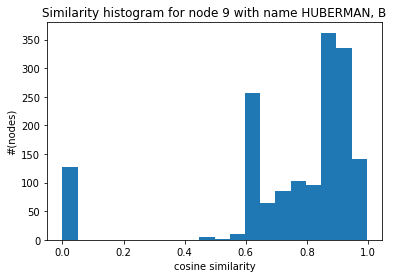

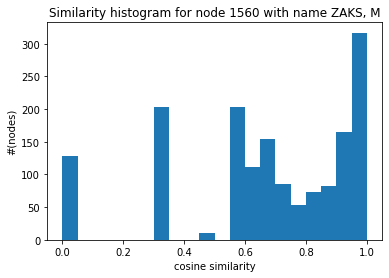

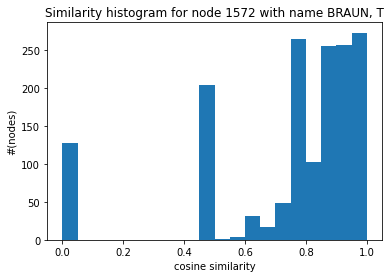

In [51]:
i = 9
tops = top_nodes(cosine_similarity(V),i,V.shape[0])
plt.hist(tops[1],bins = 20)
plt.title('Similarity histogram for node %i with name %s'%(i,Nodes[i]))
plt.xlabel('cosine similarity')
plt.ylabel('#(nodes)')
plt.show()

i = 1560
tops = top_nodes(cosine_similarity(V),i,V.shape[0])
plt.hist(tops[1],bins = 20)
plt.title('Similarity histogram for node %i with name %s'%(i,Nodes[i]))
plt.xlabel('cosine similarity')
plt.ylabel('#(nodes)')
plt.show()

i = 1572
tops = top_nodes(cosine_similarity(V),i,V.shape[0])
plt.hist(tops[1],bins = 20)
plt.title('Similarity histogram for node %i with name %s'%(i,Nodes[i]))
plt.xlabel('cosine similarity')
plt.ylabel('#(nodes)')
plt.show()

According to the histogram, can you spot some groups / roles? How many can you spot? (Clue:
look for the spikes! )

> (b) For these groups / roles in the cosine similarity histogram, take one node $u$ from each group to examine the feature vector, and draw the subgraph of the node based on its feature vector. You can draw the subgraph by hand, or you can use libraries such as networkx or graphviz.

For these drawings, you should use the local features for $u$, and pay attention to the features aggregated from its 1-hop neighbors, but feel free to ignore further features if they are difficult to incorporate. Also, you should not draw nodes that are more than 3-hops away from $u$.

In [ ]:
#Your code here

Briefly argue how different structural roles are captured in 1-2 sentences.